In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from math import ceil
from scipy import stats

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from keras.utils import to_categorical

import time

# Functions

## Data Filtering

In [2]:
def median_filter_data(df_arg, filter_columns_arg, window_size_arg):
    """Function to filter data using a median filter with a selected window of the specified columns of the transmitted dataframe
    :param df_arg: the dataframe whose column contents you want to filter
    :param filter_columns_arg: a list of columns whose contents should be filtered
    :param window_size_arg: window size for the median filter
    :return: a dataframe that contains the filtered column values
    """
    df = pd.DataFrame()
    for column in filter_columns_arg:
        # Apply median filtering to column data
        df[f'{column}_filtered'] = df_arg[column].rolling(window=window_size_arg, center=True, min_periods=1).median()
    return df

## Exploratory data analysis

In [3]:
def get_undersampled_df(df_arg, column_name_arg):
    # First, calculate the minimum number of samples across all classes
    min_samples = df_arg[column_name_arg].value_counts().min()

    # Initialize an empty DataFrame to store the undersampled data
    undersampled_df = pd.DataFrame()

    # Loop through each unique activity class and select the first min_samples for each class
    for activity_class in df_arg[column_name_arg].unique():
        class_subset = df_arg[df_arg[column_name_arg] == activity_class].iloc[:min_samples]
        undersampled_df = pd.concat([undersampled_df, class_subset])

    return undersampled_df

In [4]:
def get_discard_columns(corr_matrix_arg, important_columns_arg, df_arg):

    columns_to_discard = set()
    for column in corr_matrix_arg.columns:
        correlated_columns = corr_matrix_arg.index[
            (corr_matrix_arg[column] > 0.5) | (corr_matrix_arg[column] < -0.5)
            ]

        for correlated_column in correlated_columns:
            if column != correlated_column:
                # Prioritize which column to keep based on your criteria
                # For example, keep the column with higher variance
                if column not in important_columns_arg:
                    columns_to_discard.add(column)
                elif (column in important_columns_arg) and (correlated_column in important_columns_arg):
                    pass
                elif (column in important_columns_arg) and (correlated_column not in important_columns_arg):
                    columns_to_discard.add(correlated_column)
                else:  # both columns are not in important_columns
                    columns_to_discard.add(
                        correlated_column if df_arg[correlated_column].var() < df_arg[column].var() else column)

    return columns_to_discard

## Windowing

In [14]:
def get_windowed_df(df_arg, window_duration_arg, columns, activity_col, time_column='time'):
    # Calculate the number of data points within a 2-second window
    sampling_frequency = 1.0 / df_arg[time_column].diff().mean()  # Hz
    window_size = ceil(sampling_frequency * window_duration_arg)
    step_size = window_size // 2

    # Create a list to store the windowed dataframes
    windowed_dfs = []

    windowed_dict = {col: [] for col in columns + [activity_col]}

    # Divide the entire dataframe into 2-second windows
    for i in range(0, len(df_arg), step_size):
        window_df = df_arg.iloc[i:i + window_size]

        for col in columns:
            windowed_dict[col].append(window_df[col].values)

        # Determine the most frequent activity in the window
        most_frequent_activity = window_df[activity_col].value_counts().idxmax()
        # Assign the most frequent activity to all rows in the window
        windowed_dict[activity_col].append(most_frequent_activity)

        windowed_dfs.append(window_df)

    return pd.DataFrame.from_dict(windowed_dict)

## Feature_engineering

In [6]:
def get_statistical_measures_df(windowed_data_df, functions, data_df_columns, result_df_columns):
    """Function for creating a dataframe X_df, the columns of which correspond to the required statistical measures for
    the windows of the windowed_data_df dataframe
    :param windowed_data_df: a dataframe whose rows contain arrays of data formed as a result of windowing
    :param functions: a list of references to lambda functions that will calculate the required statistical measures
    :param data_df_columns: a list of column names of the windowed_data_df dataframe for which to find statistical
    measures
    :param result_df_columns: a list of names of the searched statistical measures of the output dataframe
    :return: X_train dataframe
    An example of using the function:
        Let's imagine we have a windowed_data_df dataframe (a dataframe formed as a result of windowing - that is, each record in a row can be an array of records for a given window), which contains the columns 'accX', 'accY', 'accZ' (the results of measuring the readings of the accelerometer on the corresponding axes).
        Inside the function, we create an X_df dataframe to which we want to add new columns with statistical measure values.
        For example, we want to calculate the statistical mean and avg absolute diff for the accelerometer readings on all three axes (the columns 'accX', 'accY', 'accZ' of data_df), so the columns of the X_df dataframe will be named, for example, 'accX_mean', 'accY_mean', ..., 'accZ_aad'.
        These values can be calculated using the lambda functions: [
            lambda x: x.mean(),
            lambda x: np.mean(np.absolute(x - np.mean(x)))
        ]
        So, the function call will look like this:
        get_statistical_measures_df(df=data_df,
                                    functions=[
                                        lambda x: x.mean(),
                                        lambda x: np.mean(np.absolute(x - np.mean(x)))
                                    ],
                                    data_df_columns=['accX', 'accY', 'accZ'],
                                    result_df_columns=['mean', 'aad'])
    """
    X_df = pd.DataFrame()
    for [function, res_column] in zip(functions, result_df_columns):
        for data_column in data_df_columns:
            X_df[f'{data_column}_{res_column}'] = windowed_data_df[data_column].apply(function)
    return X_df

## Model Training Data Preparation

In [33]:
def split_train_data(train_df_arg, training_part=0.8):
    X_train = pd.DataFrame()
    y_train = []

    X_valid = pd.DataFrame()
    y_valid = []

    counter = 0

    for activity in train_df_arg['activity'].unique():
        activity_data = train_df_arg[train_df_arg['activity'] == activity].copy()
        activity_data.reset_index(inplace=True)
        activity_data.drop('index', axis=1, inplace=True)
        split_index = int(training_part * len(activity_data))
        if counter != 0:
            X_train = pd.concat([X_train, activity_data[activity_data.columns[:-2]][:split_index]])
            X_valid = pd.concat([X_valid, activity_data[activity_data.columns[:-2]][split_index:]])
        else:
            X_train = activity_data[activity_data.columns[:-2]][:split_index]
            X_valid = activity_data[activity_data.columns[:-2]][split_index:]

        y_train.extend(list(activity_data['activity_number'].values[:split_index]))
        y_valid.extend(list(activity_data['activity_number'].values[split_index:]))

        counter += 1

    return [X_train, y_train, X_valid, y_valid]

In [56]:
def split_data(train_df_arg, test_df_arg, training_part=0.8):
    X_train, y_train, X_valid, y_valid = split_train_data(train_df_arg=train_df_arg)
    
    X_test = test_df_arg[test_df_arg.columns[:-2]]
    y_test = test_df_arg['activity_number'].values
    
    return [X_train, y_train, X_valid, y_valid, X_test, y_test]

In [82]:
def model_data_preparation(df_arg, test_df_arg, activity_dict):
    # Convert string labels to int
    df_arg['activity_number'] = df_arg['activity'].apply(lambda x: activity_dict[x])
    test_df_arg['activity_number'] = test_df_arg['activity'].apply(lambda x: activity_dict[x])
    
    X_train, y_train, X_valid, y_valid, X_test, y_test = split_data(train_df_arg=df_arg, test_df_arg=test_df_arg)
    
    y_train = np.array(y_train)
    y_valid = np.array(y_valid)
    y_test = np.array(y_test)
    
    # Convert Label Encoded target data to one-hot encoded format
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)
    y_test = to_categorical(y_test)
    
    # Scale feature vectors
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.transform(X_test)
    return X_train, y_train, X_valid, y_valid, X_test, y_test

## Pipeline functions

## Optimized pipeline

In [78]:
def perform_pipeline(df_arg, test_df_arg, activity_dict, data_columns, time_column, important_columns=[]):
    
    # Exploring measurement period and frequency stability
    df_arg = df_arg[df_arg[time_column].diff() <= df_arg[time_column].diff().mean() * 1.5]

    # Data Filtering
    df_arg[data_columns] = median_filter_data(df_arg=df_arg,
                                              filter_columns_arg=data_columns,
                                              window_size_arg=10)
    test_df_arg[data_columns] = median_filter_data(df_arg=test_df_arg,
                                                   filter_columns_arg=data_columns,
                                                   window_size_arg=10)
    
    # Exploratory Data Analysis
    df_arg = df_arg[df_arg['activity'] != 'No activity']
    test_df_arg = test_df_arg[test_df_arg['activity'] != 'No activity']
    
    # Undersample the training dataset to obtain a balanced dataframe
    df_arg = get_undersampled_df(df_arg=df_arg, column_name_arg='activity')

    # Build a correlation matrix and remove certain axes of the accelerometer or gyroscope
    sel_columns = data_columns

    # Calculate the correlation matrix for the selected columns
    corr_matrix = df_arg[sel_columns].corr()
    discard_columns = get_discard_columns(corr_matrix_arg=corr_matrix,
                                          important_columns_arg=important_columns,
                                          df_arg=df_arg)
    sel_columns = [col for col in sel_columns if col not in discard_columns]
    df_arg = df_arg[[time_column] + sel_columns + ['activity']].copy()
    
    # Windowing
    df_arg = get_windowed_df(df_arg=df_arg, window_duration_arg=2, columns=sel_columns, activity_col='activity', time_column=time_column)
    test_df_arg = get_windowed_df(df_arg=test_df_arg, window_duration_arg=2, columns=sel_columns, activity_col='activity', time_column=time_column)
    
    # Feature Engineering
    functions_list = [
        lambda x: x.mean(),  # mean
        lambda x: x.std(),  # std deviation
        lambda x: np.mean(np.absolute(x - np.mean(x))),  # avg absolute diff
        lambda x: x.min(),  # min
        lambda x: x.max(),  # max
        lambda x: x.max() - x.min(),  # range = max-min diff
        lambda x: np.median(x),  # median
        lambda x: np.percentile(x, 75) - np.percentile(x, 25),  # interquartile range
        lambda x: np.sum(x < 0),  # negative count
        lambda x: np.sum(x > 0),  # positive count
        lambda x: stats.skew(x),  # skewness = assymetry
        lambda x: stats.kurtosis(x)  # kurtosis
    ]
    y_train = df_arg['activity'].values
    result_columns = ['mean', 'std', 'aad', 'min', 'max', 'range', 'median', 'iqr', 'neg_count', 'pos_count',
                      'assymetry', 'kurtosis']
    df_arg = get_statistical_measures_df(windowed_data_df=df_arg,
                                         functions=functions_list,
                                         data_df_columns=sel_columns,
                                         result_df_columns=result_columns)
    df_arg['activity'] = y_train
    
    y_test = test_df_arg['activity'].values
    test_df_arg = get_statistical_measures_df(windowed_data_df=test_df_arg,
                                              functions=functions_list,
                                              data_df_columns=sel_columns,
                                              result_df_columns=result_columns)
    test_df_arg['activity'] = y_test
    
    # Model training
    return model_data_preparation(df_arg=df_arg, test_df_arg=test_df_arg, activity_dict=activity_dict)

## Estimation functions

In [43]:
def get_time_usage(df_arg, test_df_arg, activity_dict):
    # Measure start time
    start_time = time.time()

    # Call the pipeline function
    X_train, y_train, X_valid, y_valid, X_test, y_test = perform_pipeline(df_arg=df_arg, 
                                                                          test_df_arg=test_df_arg,
                                                                          activity_dict=activity_dict,
                                                                          time_column='time',
                                                                          data_columns = ['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ'],
                                                                          important_columns = ['accX', 'accY', 'accZ'])

    # Measure end time
    end_time = time.time()
    total_time = end_time - start_time
    return total_time

# Work with data

In [95]:
df = pd.read_csv('data/Train/Train_activities_1_2023-08-23.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63529 entries, 0 to 63528
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  63529 non-null  int64  
 1   time       63529 non-null  float64
 2   accX       63529 non-null  float64
 3   accY       63529 non-null  float64
 4   accZ       63529 non-null  float64
 5   gyrX       63529 non-null  float64
 6   gyrY       63529 non-null  float64
 7   gyrZ       63529 non-null  float64
 8   activity   63529 non-null  object 
dtypes: float64(7), int64(1), object(1)
memory usage: 4.4+ MB


In [96]:
test_df = pd.read_csv('data/Test/Test_activities_1_2023-08-23.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12557 entries, 0 to 12556
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  12557 non-null  int64  
 1   time       12557 non-null  float64
 2   accX       12557 non-null  float64
 3   accY       12557 non-null  float64
 4   accZ       12557 non-null  float64
 5   gyrX       12557 non-null  float64
 6   gyrY       12557 non-null  float64
 7   gyrZ       12557 non-null  float64
 8   activity   12557 non-null  object 
dtypes: float64(7), int64(1), object(1)
memory usage: 883.0+ KB


## Investigate optimized pipeline execution time

In [58]:
activity_dict = {'Squat': 0, 'Leg land': 1, 'Walk': 2, 'Lateral squat slide': 3, 'Jogging': 4}
print(f"Optimized pipeline")
number_of_experiments = 5
time_list = []
for i in range(number_of_experiments):
    temp_time = get_time_usage(df_arg=df, test_df_arg=test_df, activity_dict=activity_dict)
    time_list.append(temp_time)
    print(f"{i+1}) time = {temp_time:.3f} seconds")
    
print(f"average execution time = {sum(time_list) / len(time_list): .3f} seconds")

Optimized pipeline
1) time = 8.417 seconds
2) time = 8.423 seconds
3) time = 8.629 seconds
4) time = 8.418 seconds
5) time = 8.434 seconds
average execution time =  8.464 seconds


## Train NN model on my data

In [97]:
activity_dict = {'Squat': 0, 'Leg land': 1, 'Walk': 2, 'Lateral squat slide': 3, 'Jogging': 4}
# Call the pipeline function
X_train, y_train, X_valid, y_valid, X_test, y_test = perform_pipeline(df_arg=df, 
                                                                      test_df_arg=test_df,
                                                                      activity_dict=activity_dict,
                                                                      time_column='time',
                                                                      data_columns = ['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ'],
                                                                      important_columns = ['accX', 'accY', 'accZ'])

print(f'len(X_train) = {len(X_train)}')
print(f'len(y_train) = {len(y_train)}')

print(f'len(X_valid) = {len(X_valid)}')
print(f'len(y_valid) = {len(y_valid)}')

print(f'len(X_test) = {len(X_test)}')
print(f'len(y_test) = {len(y_test)}')

len(X_train) = 1440
len(y_train) = 1440
len(X_valid) = 361
len(y_valid) = 361
len(X_test) = 360
len(y_test) = 360


In [72]:
def plot_graphs(history, strings, filename=None):
    """Function to plot graphs for two training history parameters (eg accuracy and loss)
    Args:
        1) history - model training history
        2) strings - an array of names of history parameters (only the data of the first two history parameters specified in this array will be taken for graphing)
        3) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].plot(history.history[strings[0]], label=strings[0])
    axes[0].plot(history.history[f"val_{strings[0]}"], label=f"val_{strings[0]}")
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel(strings[0])
    axes[0].legend()
    
    axes[1].plot(history.history[strings[1]], label=strings[1])
    axes[1].plot(history.history[f"val_{strings[1]}"], label=f"val_{strings[1]}")
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel(strings[1])
    axes[1].legend()
    
    if filename:
        plt.savefig(f"{filename}.png", bbox_inches='tight')
    plt.show()

In [99]:
experiments_number = 5

accuracy_list = []

for i in range(experiments_number):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(60, activation='relu', input_shape=(len(X_train[0]), )))
    model.add(tf.keras.layers.Dense(30, activation='relu'))
    model.add(tf.keras.layers.Dense(15, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(5, activation='softmax'))

    # compile the keras model
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=5, verbose=0, batch_size=10, validation_data=(X_valid, y_valid))
          
    # evaluate the keras model
    loss, accuracy = model.evaluate(X_test, y_test)
        
    accuracy_list.append(accuracy)
    print(f'Accuracy: {accuracy*100:.3f}')
        
print(f'\nAverage accuracy = {np.mean(accuracy_list)*100:.3f}')

12/12 [==============================] - 0s 6ms/step - loss: 0.1145 - accuracy: 0.9778
Accuracy: 97.778
12/12 [==============================] - 0s 3ms/step - loss: 0.0786 - accuracy: 0.9778
Accuracy: 97.778
12/12 [==============================] - 0s 3ms/step - loss: 0.0809 - accuracy: 0.9833
Accuracy: 98.333
12/12 [==============================] - 0s 3ms/step - loss: 0.0897 - accuracy: 0.9833
Accuracy: 98.333
12/12 [==============================] - 0s 4ms/step - loss: 0.0843 - accuracy: 0.9861
Accuracy: 98.611

Average accuracy = 98.167


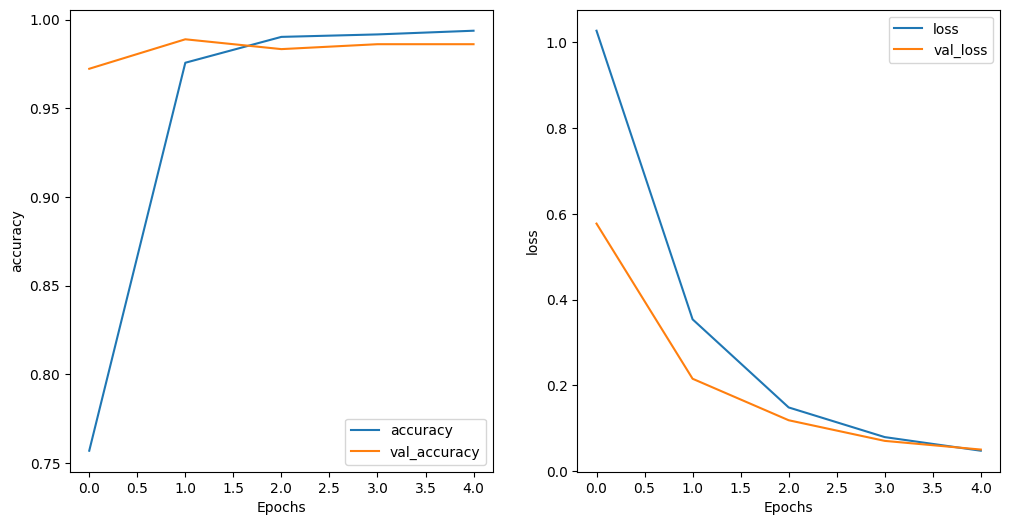

In [100]:
plot_graphs(history=history, strings=['accuracy', 'loss'])